In [ ]:
#|default_exp tmp

# Compile

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
from miniai.utils import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [ ]:
class Dropout(nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if not self.training: return x
        dist = distributions.binomial.Binomial(tensor(1.0).to(x.device), probs=1-self.p)
        return x * dist.sample(x.size()) * 1/(1-self.p)

In [ ]:
class TTD_CB(Callback):
    def before_epoch(self, learn):
        learn.model.apply(lambda m: m.train() if isinstance(m, (nn.Dropout,nn.Dropout2d)) else None)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  #(uncomment if needed,but you likely already have it)

#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
from typing import Iterator
from torch.utils.data import DataLoader, WeightedRandomSampler

class TopLossesCallback(Callback):
  epoch_preds = []
  epoch_targets = []
  
  @torch.no_grad()
  def _calculate_top_losses(self):
    preds = torch.cat(self.epoch_preds, dim=0)
    targets = torch.cat(self.epoch_targets, dim=0)
    losses = F.cross_entropy(preds, targets, reduce=False)
    return torch.topk(losses, preds.shape[0]).indices

  def after_batch(self, learn):
    if not learn.model.training:
      return
    self.epoch_preds.append(learn.preds)
    self.epoch_targets.append(learn.batch[1])

  def before_epoch(self, learn):
    self.epoch_preds = []
    self.epoch_targets = []

  def after_epoch(self, learn):
    if not learn.model.training:
      return
    learn.dls.train.sampler.top_losses = self._calculate_top_losses()

# tweaked from tommyc's version
# Before certain epoch drop a % of the training dataset with the lowest losses.
# Replace them with the the same % of the training dataset with the highest losses.
# This gives the model two opportunities to train on the most challenging images.
class CustomTrainingSampler(WeightedRandomSampler):
  def __init__(self, *args, **kwargs):
    WeightedRandomSampler.__init__(self, *args, **kwargs)
    self.data_indexes_for_epoch = []
    self.top_losses = []
    self.epoch = -1
    self.n = {
        0: 0,
        1: 0.2,
        2: 0.4,
        3: 0.2,
        4: 0
    }

  def __iter__(self) -> Iterator[int]:
      self.epoch += 1
      rand_tensor = torch.randperm(self.num_samples, generator=self.generator).tolist()
      n = int(self.n[self.epoch] * self.num_samples)

      if n != 0:
        # TODO: Cleanup the code below
        inverted_losses_for_epochs = torch.flip(torch.tensor(self.top_losses.clone().detach()[:n]), dims=(0,)).cpu()
        self.data_indexes_for_epoch = torch.tensor(self.data_indexes_for_epoch).cpu()
        self.data_indexes_for_epoch[self.top_losses[-n:].cpu()] = self.data_indexes_for_epoch[inverted_losses_for_epochs]
        self.data_indexes_for_epoch = self.data_indexes_for_epoch[rand_tensor]
        self.data_indexes_for_epoch = self.data_indexes_for_epoch.tolist()
      else:
        self.data_indexes_for_epoch = rand_tensor

      yield from self.data_indexes_for_epoch


class CustomDataLoader:
    def __init__(self, *dls): 
      self.train,self.valid = dls[:2]

    def get_sampler(num_samples, mode="train"):
      if mode != "train":
        return None
      return CustomTrainingSampler(weights=[1 for _ in range(num_samples)], num_samples=num_samples)

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
      return cls(*[DataLoader(ds, batch_size, sampler=cls.get_sampler(len(ds), mode), collate_fn=collate_dict(ds), **kwargs) for mode, ds in dd.items()])

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds = cache_dataset_as_dict(dsd.with_transform(transformi))

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5

In [ ]:
def get_model7(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Dropout2d(0.2), nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
from torchvision import transforms

In [ ]:
def tfm_batch(b, tfm_x=fc.noop, tfm_y = fc.noop): return tfm_x(b[0]),tfm_y(b[1])

In [ ]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

## Compile

In [ ]:
class CompileCB(Callback):
    order=9999
    def __init__(self):
        self.default_warmup = 1
        self.record_new()
    
    def record_new(self):
        self.static_bx, self.static_by = None, None
        self.train_g = None
        self.recording_ctx = None
        self.recording_cbs = None
        self.warmup = self.default_warmup
        self.s = torch.cuda.Stream()
        self.s.wait_stream(torch.cuda.current_stream())
        
        self.warmup_ctx = torch.cuda.stream(self.s)
        self.warmup_ctx.__enter__()
       
    def before_fit(self, learn):
        self.orig_one_batch = learn._one_batch
        learn._one_batch = partial(self._batch_warmup, learn)
        self.record_new()
       
        
    def cleanup_fit(self, learn):
        learn._one_batch = self.orig_one_batch 
        self.orig_one_batch = None

    
    def _batch_warmup(self, learn):
        if self.warmup > 0 :
            print('Warmup: ', self.warmup)
            self.warmup -=1
            self.orig_one_batch()
        else: 
            print('finalizing warm up', self.warmup, self.warmup_ctx)
            self.warmup_ctx.__exit__(None, None, None)
            torch.cuda.current_stream().wait_stream(self.s)
            del self.s
            print('Recording one batch')
            self.train_g = torch.cuda.CUDAGraph()
            learn.opt.zero_grad(set_to_none=True)
            #with torch.no_grad(): print('means', [p.mean().item() for p in model.parameters()])
            self.recording_ctx = torch.cuda.graph(self.train_g)
            try:
                self.orig_one_batch()
            finally: 
                if self.recording_ctx is not None:
                    self.recording_ctx.__exit__(None, None, None)
                    self.recording_ctx = None
            #with torch.no_grad(): print('means', [p.mean().item() for p in model.parameters()])
            learn._one_batch = partial(self._batch_with_graph, learn)
            print('Recording complete')
            learn._one_batch()
    
    def before_batch(self,learn):
        if self.recording_ctx is not None:
            self.recording_cbs = learn.cbs
            learn.cbs=[self]
            self.recording_ctx.__enter__()
            
    def after_batch(self, learn):
        if self.recording_ctx is not None:
            self.static_bx, self.static_by = learn.batch
            self.static_preds = learn.preds
            self.static_loss = learn.loss
            tmp = learn.loss.clone()
            self.recording_ctx.__exit__(None, None, None)
            print(tmp)
            
            self.recording_ctx = None
        if self.recording_cbs is not None:
            learn.cbs = self.recording_cbs
            self.recording_cbs = None
            # no after callback as this was not actual run
            
            
    def _batch_with_graph(self, learn):
        if not learn.training: return self.orig_one_batch() # todo compile validation graph
        assert self.train_g is not None, 'batch_with_graph can be called only when a valid train_g is recorded'
        bx, by = learn.batch
        self.static_bx[:bx.shape[0]].copy_(bx)
        self.static_by[:bx.shape[0]].copy_(by)
        learn.batch = (self.static_bx, self.static_by)
        learn.callback('before_batch')
        self.train_g.replay()
        
        learn.preds = self.static_preds
        learn.callback('after_predict')
        learn.loss = self.static_loss
        learn.callback('after_loss')
        if learn.training:
            learn.callback('after_backward')
            learn.callback('after_step')
        learn.callback('after_batch')

In [ ]:
Learner??

Init signature:
Learner(
    model,
    dls=(0,),
    loss_func=<function mse_loss at 0x7f070154d480>,
    lr=0.1,
    cbs=None,
    opt_func=<class 'torch.optim.sgd.SGD'>,
)
Docstring:      <no docstring>
Source:        
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self

In [ ]:
from miniai.learner import Mean, master_bar, progress_bar


In [ ]:
class DevMetricsCB(Callback):
    def __init__(self, *ms, device=def_device, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        self.device = def_device

    def _log(self, d): print(d)
    def before_fit(self, learn): 
        learn.metrics = self
        for cb in learn.cbs: 
            if isinstance(cb, DeviceCB): 
                self.device = cb.device
                
    def before_epoch(self, learn): 
        for o in self.all_metrics.values(): 
            o.reset()
            o.to(self.device)
    
    @torch.no_grad()
    def after_epoch(self, learn):
        log = {k:f'{to_cpu(v.compute()):.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    @torch.no_grad()
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values(): m.update(learn.preds, y)
        self.loss.update(learn.loss, weight=len(x))

class LazyProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): 
        self.plot = plot
        self.count = 0
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.dev_losses = []
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        if self.plot:
            for l in self.dev_losses: self.losses.append(to_cpu(l))
            self.dev_losses=[]
            #print(self.losses[:10])
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])
        
    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        #learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.dev_losses.append(learn.loss.detach())
       

In [ ]:
class TrainLearner2(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): 
        #import pdb;pdb.set_trace()
        self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

batchsize 256


accuracy,loss,epoch,train
0.853,0.642,0,train
0.880,0.510,0,eval
0.908,0.449,1,train
0.896,0.438,1,eval


Warmup:  1
finalizing warm up 0 <torch.cuda.StreamContext object>
Recording one batch
tensor(0., device='cuda:0', grad_fn=<CloneBackward0>)
Recording complete
[tensor(2.86), tensor(1.68), tensor(1.23), tensor(1.24), tensor(1.18), tensor(1.17), tensor(1.06), tensor(0.99), tensor(1.05), tensor(0.98)]


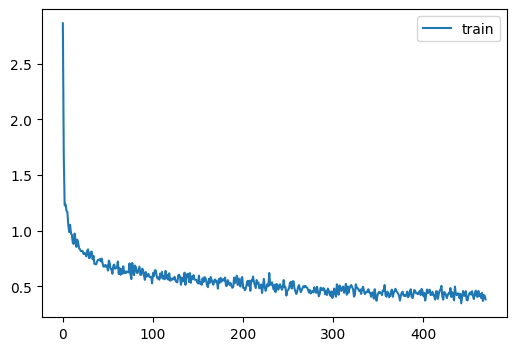

[tensor(2.86), tensor(1.68), tensor(1.23), tensor(1.24), tensor(1.18), tensor(1.17), tensor(1.06), tensor(0.99), tensor(1.05), tensor(0.98)]
[tensor(2.86), tensor(1.68), tensor(1.23), tensor(1.24), tensor(1.18), tensor(1.17), tensor(1.06), tensor(0.99), tensor(1.05), tensor(0.98)]
[tensor(2.86), tensor(1.68), tensor(1.23), tensor(1.24), tensor(1.18), tensor(1.17), tensor(1.06), tensor(0.99), tensor(1.05), tensor(0.98)]
Fit 2 in: 12.19s, setup: 0.00s, 5.80 ± 0.27s per epoch, 3556342.04 ± 77099658.04s per batch


In [ ]:
#%%timeit -n 1 -r 1

metrics_dev = DevMetricsCB(accuracy=MulticlassAccuracy())

timeit= TimeItCB()
#  metrics, TopLossesCallback(), ProgressCB(plot=True), 
cbs = [DeviceCB(), metrics_dev, LazyProgressCB(plot=True),  timeit]
def act_gr(): return nn.Hardswish()
iw = partial(init_weights, leaky=0.0003)

set_seed(42)
epochs = 2
m = 1
lr = 1e-2 *m
dls = DataLoaders.from_dd(tds, bs*m, num_workers=0)
print ('batchsize', dls.train.batch_size)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), CompileCB()]
model = get_model7(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner2(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=partial(optim.AdamW, capturable=True))
learn.fit(epochs)

In [ ]:
losses_bad = learn.cbs[2].losses

In [ ]:
with torch.no_grad(): print('v', [p.mean().item() for p in model.parameters()])

v [-0.006091793067753315, -0.018843404948711395, 1.0004208087921143, -0.00028873246628791094, -0.0031673943158239126, -0.00030565913766622543, 1.0055911540985107, 0.003061870113015175, 0.020558271557092667, 0.10808371007442474, -0.003030346008017659, 0.010156992822885513, 0.9992262125015259, 0.002205555560067296, -0.0027183517813682556, -0.0006321689579635859, 0.9958805441856384, -0.00010558095527812839, -0.00657886266708374, 0.0232921801507473, -0.0012758182128891349, -0.00461848359555006, 0.9993218779563904, 0.001460287137888372, -0.0014141496503725648, 0.0020273844711482525, 0.9972966313362122, -0.0012639594497159123, -0.0036335440818220377, 0.00214223749935627, -0.0007327210623770952, 0.002241025445982814, 1.0008165836334229, -0.0028631058521568775, -0.0006295196362771094, -0.0033440820407122374, 1.0018295049667358, -0.0032577370293438435, -0.002059980994090438, -0.004497181624174118, -0.0005643723998218775, -0.000500344904139638, 1.0009853839874268, -0.004588929936289787, -0.00051

batchsize 256


accuracy,loss,epoch,train
0.854,0.529,0,train
0.886,0.332,0,eval
0.919,0.247,1,train
0.922,0.226,1,eval


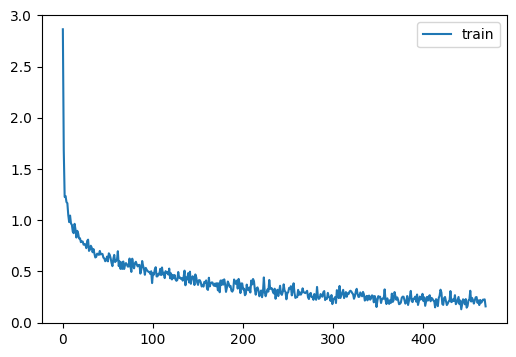

Fit 2 in: 13.48s, setup: 0.00s, 6.45 ± 0.18s per epoch, 0.01 ± 0.00s per batch


In [ ]:
metrics=DevMetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, LazyProgressCB(plot=True), timeit]

def act_gr(): return nn.Hardswish()
iw = partial(init_weights, leaky=0.0003)

set_seed(42)
epochs = 2
m = 1
lr = 1e-2 *m
dls = DataLoaders.from_dd(tds, bs*m, num_workers=0)
print ('batchsize', dls.train.batch_size)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model7(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

batchsize 256


accuracy,loss,epoch,train
0.854,0.529,0,train
0.886,0.336,0,eval
0.920,0.249,1,train
0.921,0.227,1,eval


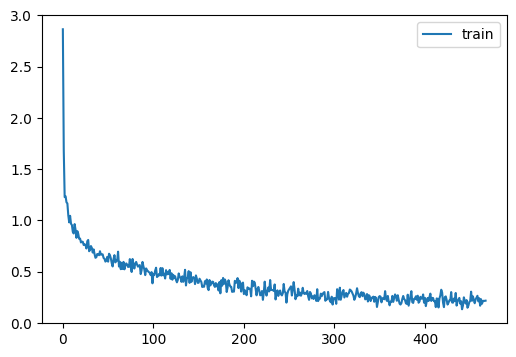

Fit 2 in: 13.53s, setup: 0.00s, 6.48 ± 0.20s per epoch, 0.01 ± 0.00s per batch


In [ ]:
metrics=DevMetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, LazyProgressCB(plot=True), timeit]

def act_gr(): return nn.Hardswish()
iw = partial(init_weights, leaky=0.0003)

set_seed(42)
epochs = 2
m = 1
lr = 1e-2 *m
dls = DataLoaders.from_dd(tds, bs*m, num_workers=0, drop_last=True)
print ('batchsize', dls.train.batch_size)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model7(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn2 = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn2.fit(epochs)

# Compile partially using make_graphed_callables

In [ ]:
class CompilePartiallyCB(Callback):
    order=9999
    def __init__(self): pass
       
        
    def before_batch(self,learn):
        if not learn.training: return
            
        if not getattr(learn.model, 'graphed_shape', False):
            learn.model.graphed_shape = learn.batch[0].shape
            learn.model = torch.cuda.make_graphed_callables(learn.model, (learn.batch[0],))
        if learn.batch[0].shape != learn.model.graphed_shape:
            raise CancelBatchException()
   

In [ ]:
batch = next(iter(dls.train))
batch = batch[0].to('cuda'), batch[1].to('cuda')

In [ ]:
#torch.cuda.make_graphed_callables??

batchsize 256


accuracy,loss,epoch,train
0.856,0.524,0,train
0.884,0.348,0,eval
0.918,0.252,1,train
0.920,0.233,1,eval


[tensor(2.85), tensor(1.66), tensor(1.18), tensor(1.20), tensor(1.12), tensor(1.09), tensor(1.00), tensor(0.93), tensor(1.00), tensor(0.94)]


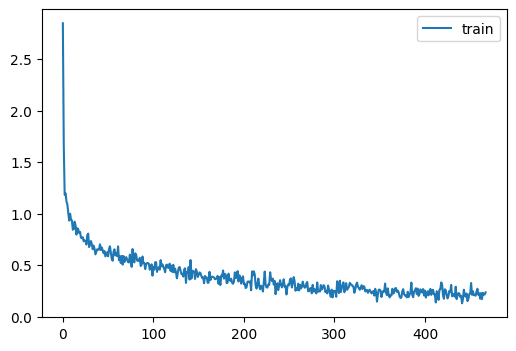

[tensor(2.85), tensor(1.66), tensor(1.18), tensor(1.20), tensor(1.12), tensor(1.09), tensor(1.00), tensor(0.93), tensor(1.00), tensor(0.94)]
[tensor(2.85), tensor(1.66), tensor(1.18), tensor(1.20), tensor(1.12), tensor(1.09), tensor(1.00), tensor(0.93), tensor(1.00), tensor(0.94)]
[tensor(2.85), tensor(1.66), tensor(1.18), tensor(1.20), tensor(1.12), tensor(1.09), tensor(1.00), tensor(0.93), tensor(1.00), tensor(0.94)]
Fit 2 in: 16.87s, setup: 0.00s, 8.14 ± 0.41s per epoch, 7127823.84 ± 109034738.12s per batch


In [ ]:
#%%timeit -n 1 -r 1

metrics_dev = DevMetricsCB(accuracy=MulticlassAccuracy())

timeit= TimeItCB()
#  metrics, TopLossesCallback(), ProgressCB(plot=True), 
cbs = [DeviceCB(), metrics_dev, LazyProgressCB(plot=True),  timeit]
def act_gr(): return nn.Hardswish()
iw = partial(init_weights, leaky=0.0003)

set_seed(42)
epochs = 2
m = 1
lr = 1e-2 *m
dls = DataLoaders.from_dd(tds, bs*m, num_workers=0)
print ('batchsize', dls.train.batch_size)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), CompilePartiallyCB()]
model = get_model7(act_gr, norm=nn.BatchNorm2d).apply(iw).to('cuda')
# model.graphed_shape = batch[0].shape
# model = torch.cuda.make_graphed_callables(model, (batch[0],))
learn = TrainLearner2(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=partial(optim.AdamW, capturable=True))
learn.fit(epochs)

In [ ]:
def get_dls(train_ds, valid_ds, bs, drop_last=False, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, drop_last=drop_last, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))
class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

batchsize 256


accuracy,loss,epoch,train
0.855,0.524,0,train
0.876,0.356,0,eval
0.918,0.251,1,train
0.920,0.233,1,eval


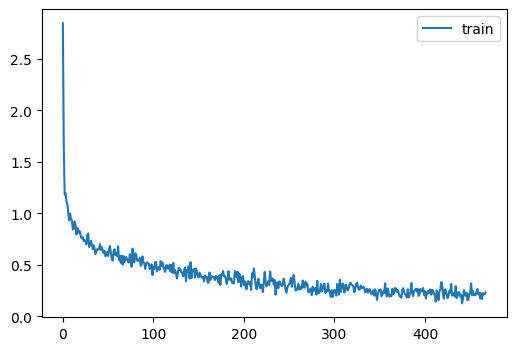

Fit 2 in: 16.72s, setup: 0.00s, 8.07 ± 0.33s per epoch, 0.03 ± 0.03s per batch


In [ ]:
#%%timeit -n 1 -r 1

metrics_dev = DevMetricsCB(accuracy=MulticlassAccuracy())

timeit= TimeItCB()
#  metrics, TopLossesCallback(), ProgressCB(plot=True), 
cbs = [DeviceCB(), metrics_dev, LazyProgressCB(plot=True),  timeit]
def act_gr(): return nn.Hardswish()
iw = partial(init_weights, leaky=0.0003)

set_seed(42)
epochs = 2
m = 1
lr = 1e-2 *m
dls = DataLoaders.from_dd(tds, bs*m, num_workers=0, drop_last=True)
print ('batchsize', dls.train.batch_size)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), CompilePartiallyCB()]
model = get_model7(act_gr, norm=nn.BatchNorm2d).apply(iw).to('cuda')
# model.graphed_shape = batch[0].shape
# model = torch.cuda.make_graphed_callables(model, (batch[0],))
learn = TrainLearner2(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=partial(optim.AdamW, capturable=True))
learn.fit(epochs)

batchsize 256


accuracy,loss,epoch,train
0.854,0.529,0,train
0.882,0.348,0,eval
0.920,0.248,1,train
0.922,0.228,1,eval


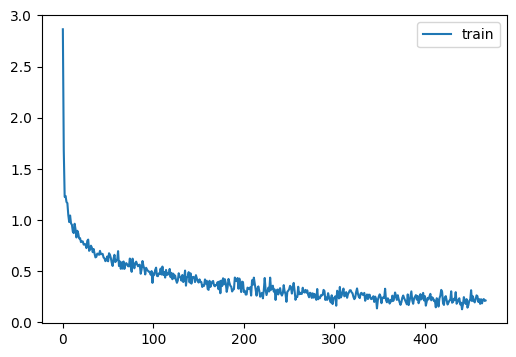

Fit 2 in: 16.89s, setup: 0.00s, 8.15 ± 0.16s per epoch, 0.03 ± 0.01s per batch


In [ ]:
#%%timeit -n 1 -r 1

metrics_dev = DevMetricsCB(accuracy=MulticlassAccuracy())

timeit= TimeItCB()
#  metrics, TopLossesCallback(), ProgressCB(plot=True), 
cbs = [DeviceCB(), metrics_dev, LazyProgressCB(plot=True),  timeit]
def act_gr(): return nn.Hardswish()
iw = partial(init_weights, leaky=0.0003)

set_seed(42)
epochs = 2
m = 1
lr = 1e-2 *m
dls = DataLoaders.from_dd(tds, bs*m, num_workers=0, drop_last=True)
print ('batchsize', dls.train.batch_size)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model7(act_gr, norm=nn.BatchNorm2d).apply(iw).to('cuda')
learn = TrainLearner2(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=partial(optim.AdamW, capturable=True))
learn.fit(epochs)

batchsize 256


accuracy,loss,epoch,train
0.854,0.531,0,train
0.884,0.344,0,eval
0.919,0.250,1,train
0.921,0.230,1,eval


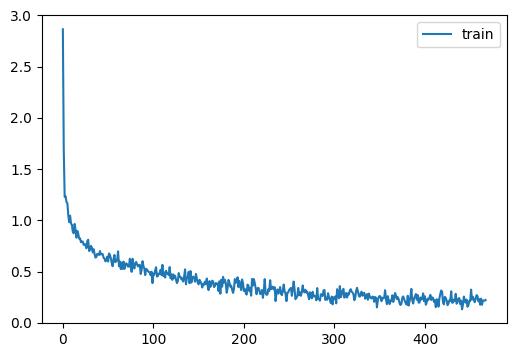

Fit 2 in: 52.79s, setup: 0.00s, 26.09 ± 0.25s per epoch, 0.05 ± 0.01s per batch


In [ ]:
#%%timeit -n 1 -r 1

metrics = MetricsCB(accuracy=MulticlassAccuracy())

timeit= TimeItCB()
#  metrics, TopLossesCallback(), ProgressCB(plot=True), 
cbs = [DeviceCB(), metrics, ProgressCB(plot=True),  timeit]
def act_gr(): return nn.Hardswish()
iw = partial(init_weights, leaky=0.0003)

set_seed(42)
epochs = 2
m = 1
lr = 1e-2 *m
dls = DataLoaders.from_dd(tds, bs*m, num_workers=0, drop_last=True)
print ('batchsize', dls.train.batch_size)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model7(act_gr, norm=nn.BatchNorm2d).apply(iw).to('cuda')
learn = TrainLearner2(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=partial(optim.AdamW, capturable=True))
learn.fit(epochs)